First, we install the HuggingFace Transformers library

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install Pillow
!pip install matplotlib
!pip install opencv-python

In [3]:
from transformers.utils import send_example_telemetry

send_example_telemetry("zeroshot_object_detection_with_owlvit_notebook", framework="pytorch")

In [4]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

`AnnotionFormat` is deprecated and will be removed in v4.38. Please use `transformers.image_utils.AnnotationFormat` instead.


config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

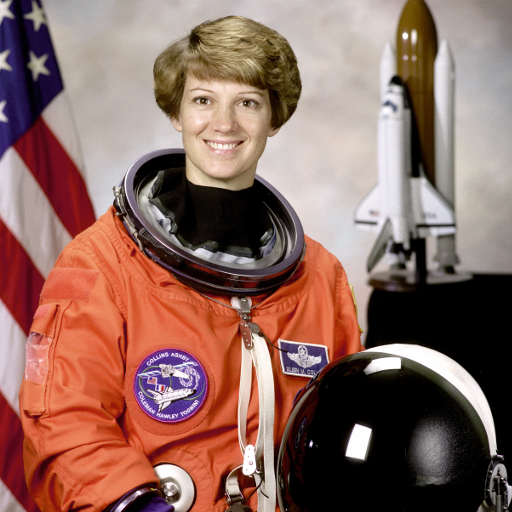

In [5]:
import cv2
import skimage
import numpy as np
from PIL import Image

# Download sample image
image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

# Text queries to search the image for
text_queries = ["human face", "rocket", "nasa badge", "star-spangled banner"]

image

In [6]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [7]:
# Process image and text inputs
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

input_ids: torch.Size([4, 16])
attention_mask: torch.Size([4, 16])
pixel_values: torch.Size([1, 3, 768, 768])


In [8]:
# Set model in evaluation mode
model = model.to(device)
model.eval()

# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([1, 576, 4])
pred_boxes: shape of torch.Size([1, 576, 4])
text_embeds: shape of torch.Size([1, 4, 512])
image_embeds: shape of torch.Size([1, 24, 24, 768])
class_embeds: shape of torch.Size([1, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([4, 16, 512])
pooler_output: shape of torch.Size([4, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


In [9]:
import matplotlib.pyplot as plt

from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()

# Load example image
image_size = model.config.vision_config.image_size
image = mixin.resize(image, image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.1

# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

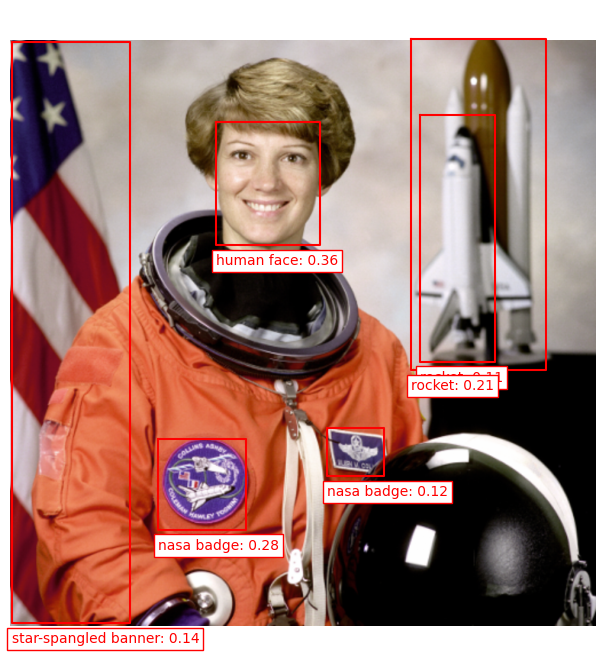

In [10]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue

      cx, cy, w, h = box
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })

plot_predictions(input_image, text_queries, scores, boxes, labels)

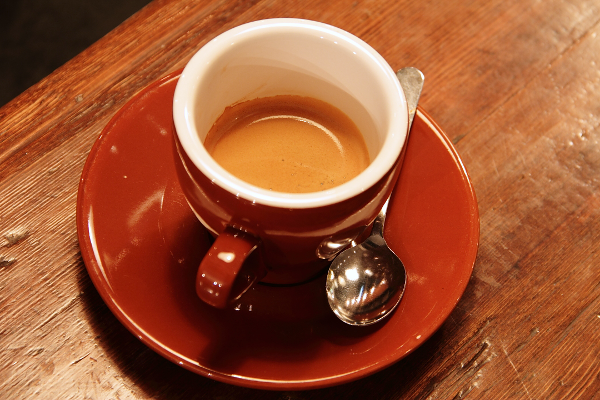

In [11]:
# Download the coffee mug image
image = skimage.data.coffee()
image = Image.fromarray(np.uint8(image)).convert("RGB")
image

In [13]:
# Preprocessing
images = [skimage.data.astronaut(), skimage.data.coffee()]
images = [Image.fromarray(np.uint8(img)).convert("RGB") for img in images]

# Nexted list of text queries to search each image for
text_queries = [["human face", "rocket", "nasa badge", "star-spangled banner"], ["coffee mug", "spoon", "plate"]]

# Process image and text inputs
inputs = processor(text=text_queries, images=images, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
  print(f"{key}: {val.shape}")

input_ids: torch.Size([8, 16])
attention_mask: torch.Size([8, 16])
pixel_values: torch.Size([2, 3, 768, 768])


In [14]:
# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([2, 576, 4])
pred_boxes: shape of torch.Size([2, 576, 4])
text_embeds: shape of torch.Size([2, 4, 512])
image_embeds: shape of torch.Size([2, 24, 24, 768])
class_embeds: shape of torch.Size([2, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([8, 16, 512])
pooler_output: shape of torch.Size([8, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([2, 577, 768])
pooler_output: shape of torch.Size([2, 768])


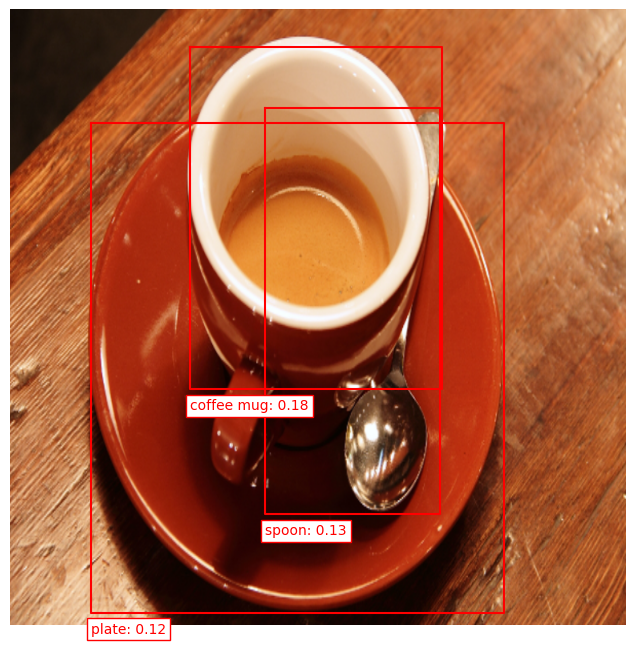

In [17]:
# Let's plot the predictions for the second image
image_idx = 1
image_size = model.config.vision_config.image_size
image = mixin.resize(images[image_idx], image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.1

# Get prediction logits
logits = torch.max(outputs["logits"][image_idx], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][image_idx].cpu().detach().numpy()

plot_predictions(input_image, text_queries[image_idx], scores, boxes, labels)

In [18]:
# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([img.size[::-1] for img in images]).to(device)

# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

# Loop over predictions for each image in the batch
for i in range(len(images)):
    print(f"\nProcessing image {i}")
    text = text_queries[i]
    boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

    score_threshold = 0.1
    for box, score, label in zip(boxes, scores, labels):
        box = [round(i, 2) for i in box.tolist()]

        if score >= score_threshold:
            print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")


Processing image 0
Detected human face with confidence 0.357 at location [180.23, 71.53, 271.25, 178.76]
Detected rocket with confidence 0.106 at location [358.81, 64.85, 424.18, 280.84]
Detected star-spangled banner with confidence 0.138 at location [1.43, 1.26, 105.38, 509.68]
Detected rocket with confidence 0.211 at location [350.98, -1.17, 468.6, 288.51]
Detected nasa badge with confidence 0.281 at location [129.58, 348.54, 206.46, 427.98]
Detected nasa badge with confidence 0.12 at location [277.15, 338.86, 327.42, 380.85]

Processing image 1
Detected coffee mug with confidence 0.175 at location [175.23, 24.72, 420.98, 246.83]
Detected spoon with confidence 0.132 at location [248.54, 63.72, 418.45, 327.98]
Detected plate with confidence 0.115 at location [78.9, 74.04, 481.06, 391.81]


/usr/local/lib/python3.10/dist-packages/transformers/models/owlvit/image_processing_owlvit.py:430: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.
  warnings.warn(


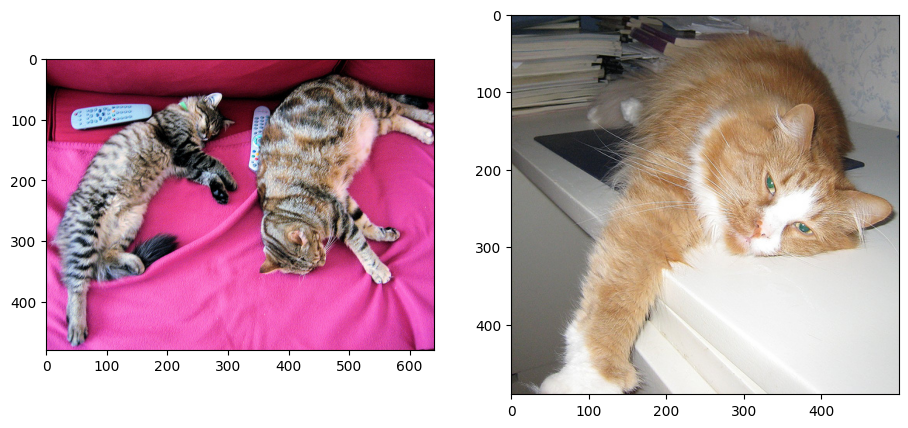

In [19]:
import cv2
import requests
from matplotlib import rcParams

# Set figure size
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8

# Input image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
target_sizes = torch.Tensor([image.size[::-1]])

# Query image
query_url = "http://images.cocodataset.org/val2017/000000058111.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

# Display input image and query image
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(query_image)

In [20]:
# Process input and query image
inputs = processor(images=image, query_images=query_image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

query_pixel_values: torch.Size([1, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])


In [21]:
# Get predictions
with torch.no_grad():
  outputs = model.image_guided_detection(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([1, 576, 1])
image_embeds: shape of torch.Size([1, 24, 24, 768])
query_image_embeds: shape of torch.Size([1, 24, 24, 768])
target_pred_boxes: shape of torch.Size([1, 576, 4])
query_pred_boxes: shape of torch.Size([1, 576, 4])
class_embeds: shape of torch.Size([1, 576, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


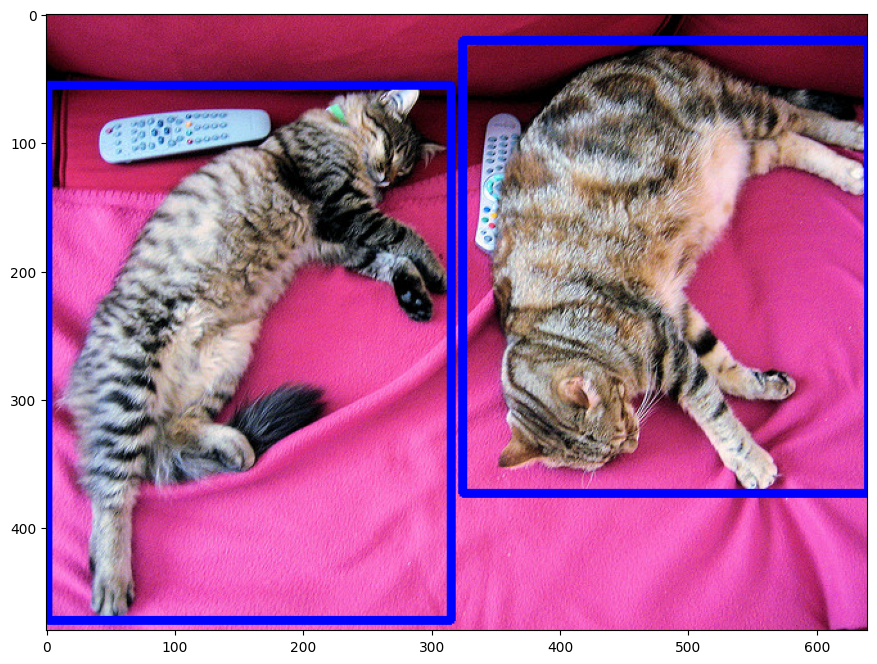

In [22]:
img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
outputs.logits = outputs.logits.cpu()
outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()

results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.6, nms_threshold=0.3, target_sizes=target_sizes)
boxes, scores = results[0]["boxes"], results[0]["scores"]

# Draw predicted bounding boxes
for box, score in zip(boxes, scores):
    box = [int(i) for i in box.tolist()]

    img = cv2.rectangle(img, box[:2], box[2:], (255,0,0), 5)
    if box[3] + 25 > 768:
        y = box[3] - 10
    else:
        y = box[3] + 25

plt.imshow(img[:,:,::-1])